# Deep Learning for Computer Vision:  Assignment 1


## Computer Science: COMS W 4995 004


### Due: February 9, 2017

#### Problem 1

You are asked to produce a minumum error rate classifier for a 3-class classification problem. Your feature space is 2-dimensional. Let's say the class conditional density functions (or likelihoods) are known and given by $\rho({\bf x}|y_i)$
where ${\bf x}$ is your feature and $y_i$ specifies the class. Let's also assume that the priors $P(y_i)$ are also given. (Both of these are specified below.) Compute the decision regions for each of the three classes. Hint: you can show this by densely generating sample points ${\bf x}_j \in X$ in the feature space, classifying them, and then plotting and coloring them according to their predicted label.

Let the ccds and priors be given as:
    

$$\rho({\bf x}|y_1) \sim N({\bf \mu}_1, \Sigma_1)  \text{ and } P(y_1) = 0.5\,\, \text{ where } \,\, 
{\bf \mu}_1 = \left[\begin{array}{c} 1 \\ 1  \end{array} \right]
\,\, \text{ and } 
\Sigma_1 = \left[\begin{array}{cc} 1 & 0 \\ 0 & 0.5  \end{array} \right] $$


$$\rho({\bf x}|y_2) \sim N({\bf \mu}_2, \Sigma_2)  \text{ and } P(y_2) = 0.25\,\, \text{ where } \,\, 
{\bf \mu}_2 = \left[\begin{array}{c} 1 \\ 0  \end{array} \right]
\,\, \text{ and } 
\Sigma_2 = \left[\begin{array}{cc} 0.5 & 0 \\ 0 & 1  \end{array} \right] $$


$$\rho({\bf x}|y_3) \sim N({\bf \mu}_3, \Sigma_3)  \text{ and } P(y_3) = 0.25\,\, \text{ where } \,\, 
{\bf \mu}_3 = \left[\begin{array}{c} 0 \\ 0  \end{array} \right]
\,\, \text{ and } 
\Sigma_3 = \left[\begin{array}{cc} 0.5 & 0 \\ 0 & 0.5  \end{array} \right] $$

Remember all you need to do is to use Bayes Theorem to get the expression for $P(y_i|{\bf x})$, then for each sample ${\bf x}_j \in X$ choose the $i$ with the highest aposteriori probability.

In [12]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

In [13]:
def generate_sample_points(x_range, y_range, num_points):
    x1_points = []
    x2_points = []
    for i in np.linspace(-x_range, x_range, num_points):
        for j in np.linspace(-y_range, y_range, num_points):
            x1_points.append(i)
            x2_points.append(j)
    return (x1_points, x2_points)

def calculate_bayesian_denominator(sample, means, variances, priors):
    denominator = 0
    for (mean, variance, prior) in zip(means, variances, priors):
        value = (multivariate_normal(mean, variance).pdf(sample)) * prior
        denominator = denominator + value
    return denominator

def calculate_bayesian_prob(sample, mean, variance, prior, denominator_value):
    numerator_value = (multivariate_normal(mean, variance).pdf(sample)) * (prior)
    return (numerator_value) / (denominator_value)

def calculate_max_bayesian(sample, means, variances, priors):
    denominator_value = calculate_bayesian_denominator(sample, means, variances, priors)
    values = []
    for (mean, variance, prior) in zip(means, variances, priors):
        values.append(calculate_bayesian_prob(sample, mean, variance, prior, denominator_value))
    return ((values.index(max(values))) + 1)

def label_points(x1_points, x2_points, means, variances, priors):
    labeled_points = []
    for (x1, x2) in zip(x1_points, x2_points):
        # Sample is generated using the separate dimensions we randomly generated.
        sample = [x1, x2]
        sample_class = calculate_max_bayesian(sample, means, variances, priors)
        labeled_points.append(sample_class)
    return labeled_points

def filter_points_by_class(desired_class, points):
    filtered_points = filter(lambda point: point[2] == desired_class, points)
    return zip(*filtered_points)

def plot_labeled_points(x1_points, x2_points, labeled_points, num_classes):
    # Colors taken from online matplotlib tutorial
    colors = ['c', 'crimson', 'chartreuse']
    plots = []
    for i in range(0,num_classes):
        points = filter_points_by_class((i+1), zip(x1_points, x2_points, labeled_points))
        scatter = plt.scatter(list(points[0]), list(points[1]), color=colors[i])
        plots.append(scatter)
    plt.legend(tuple(plots), ('Class 1', 'Class 2', 'Class 3'), scatterpoints=1,
           loc='lower left', ncol=3, fontsize=8)
    plt.title('Minimum Error Rate Classifier')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.show()


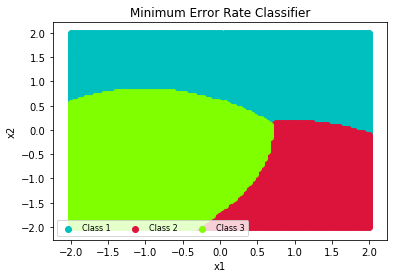

In [14]:
# Data taken from above.
class_means = [[1.0, 1.0], [1.0, 0.0], [0.0, 0.0]]
class_variances = [[[1.0, 0.0], [0.0, 0.5]],
                   [[0.5, 0.0], [0.0, 1.0]],
                   [[0.5, 0.0], [0.0, 0.5]]]
class_priors = [0.5, 0.25, 0.25]

# Generates dense data in the range -2 to 2 in each dimension.
(x1_points, x2_points) = generate_sample_points(2, 2, 100)
labeled_points = label_points(x1_points, x2_points, class_means, class_variances, class_priors)
plot_labeled_points(x1_points, x2_points, labeled_points, len(class_means))

#### Problem 2

Implement the Pegasos algorithm for finding a linear SVM classifier which separates the training data generated below. Experiment with three different choices for the regularization parameter and plot the resulting separating plane. Hint: the algorithm might show better convergence if you use the projection normalization step. Also, you can consult with any literature beyond the course notes, but you must write your own code.

In [15]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

In [16]:
# Let's make up some random data to use to build our SVM classifier
data = pd.DataFrame(np.zeros((500, 3)), columns=['x1', 'x2', 'y'])

for i in range(len(data.index)):
    x1 = random.randint(20,100)
    if np.random.random() > 0.5:
        data.iloc[i,0] = 1.0 * x1 
        data.iloc[i,1] = 0.25 * x1 + 50.0 * (random.random() - 0.5) + 65.0
        data.iloc[i,2] = 1.0
    else:
        data.iloc[i,0] = 1.0 * x1
        data.iloc[i,1] = 0.24 * x1 + 50.0 * (random.random() - 0.5) + 0.0 
        data.iloc[i,2] = -1.0
    
# Add in a stray point
data.iloc[0,0] = 50.0
data.iloc[0,1] = 0.25 * x1 + 25.0
data.iloc[0,2] = 1.0

# Now let's normalize this data.

data.iloc[:,0] = (data.iloc[:,0] - data['x1'].mean()) / data['x1'].std()
data.iloc[:,1] = (data.iloc[:,1] - data['x2'].mean()) / data['x2'].std()

data.head()
data.describe()

,x1,x2,y
count,5.000000e+02,5.000000e+02,500.000000
mean,-8.171241e-17,7.815970e-17,-0.084000
std,1.000000e+00,1.000000e+00,0.997464
min,-1.757845e+00,-1.692807e+00,-1.000000
25%,-9.040246e-01,-8.706881e-01,-1.000000
50%,3.517738e-02,-2.277943e-01,-1.000000
75%,8.889974e-01,9.119791e-01,1.000000
max,1.657435e+00,1.879156e+00,1.000000


In [17]:
# set X (training data) and y (target variable)
cols = data.shape[1]
X = data.iloc[:,0:cols-1]
y = data.iloc[:,cols-1:cols]

X = np.matrix(X.values)
y = np.matrix(y.values)

In [18]:
# Sloppy function for plotting our data
def plot_data(X, y, weights):
    
    fig, ax = plt.subplots(figsize=(12,8))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

    y_predict = y > 0
    indices_0 = [k for k in range(0, X.shape[0]) if not y_predict[k]]
    indices_1 = [k for k in range(0, X.shape[0]) if y_predict[k]]

    ax.plot(X[indices_0, 0], X[indices_0,1], marker='o', linestyle='', ms=5, label='-1')
    ax.plot(X[indices_1, 0], X[indices_1,1], marker='o', linestyle='', ms=5, label='1')

    ax.legend()
    ax.legend(loc=2)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title('Training Data')

    colors = ['blue', 'red', 'green']
    plots = []
    labels = []
    for i, (c, weight) in enumerate(weights):
        min_x, max_x = ax.get_xlim()
        slope = (-weight[0] / weight[1])
        point_1 = [min_x, max_x]
        point_2 = [(min_x * slope), (max_x * slope)]
        label = 'C = ' + str(c)
        line_plot, = plt.plot(point_1,point_2,'k-', color=colors[i % len(colors)], label=label)
        plots.append(line_plot)
        labels.append(label)
    plt.legend(plots, labels)
    plt.show()

In [19]:
def run_pegasos_algorithm(lambda_param, T, training_data, training_labels):
    # Create our list of weights - number of iterations
    w = np.zeros((T+1, 2))
    for t in range(0, T):
        current_weight = w[t] # wt
        random_index = random.randint(0, len(training_data) - 1) # it
        training_example = training_data[random_index] # xit
        training_label = training_labels[random_index] # yit
        learning_rate = (1.0 / (lambda_param * ((t+1)))) # nt
        if (training_label * np.inner(current_weight.T, training_example)) < 1:
            w[t+1] = ((1 - (learning_rate * lambda_param)) * current_weight) + \
                        (learning_rate * training_label * training_example) 
        else:
            w[t+1] = ((1 - (learning_rate * lambda_param)) * current_weight)
        # Normalization step
        normalization_term = (1 / np.sqrt(lambda_param)) / (np.linalg.norm(w[t+1]))
        w[t+1] = w[t+1] * min(1, normalization_term)
    return w[T]

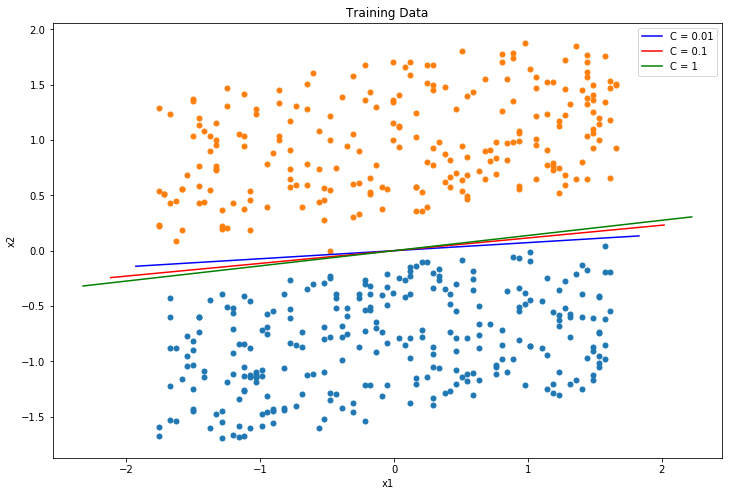

In [22]:
C = [0.01, .1, 1]
weights = []
num_iterations = 20000
for c in C:
    lambda_param = (2.0 / (len(X) * c))
    current_weight = run_pegasos_algorithm(lambda_param, num_iterations, X, y)
    weights.append((c, current_weight))
plot_data(X, y, weights)